<a href="https://colab.research.google.com/github/simonaron1111/GA_algoritmusok/blob/main/Simon_%C3%81ron_GA_bev_ACO_Projekt_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACO Projekt – Gráfos optimalizálás (TSM stílus)

Ebben a notebookban egy teljes ACO-implementációt kell készítened
egy gráfos feladatra (pl. legrövidebb út vagy körút keresése).

## 1. Gráf definiálása / betöltése

In [10]:
# TODO: gráf definiálása vagy betöltése
graph = {
    0: {1: 82.96, 2: 131.77, 3: 52.05, 4: 43.51, 5: 127.72, 6: 127.41, 7: 104.01, 8: 140.56, 9: 34.2, 10: 138.68, 11: 65.28},
    1: {2: 129.4, 3: 126.4, 4: 48.57, 5: 57.54, 6: 49.94, 7: 98.8, 8: 74.02, 9: 115.33, 10: 142.45, 11: 18.81},
    2: {3: 121.99, 4: 143.86, 5: 109.09, 6: 171.16, 7: 31.53, 8: 104.68, 9: 134.83, 10: 14.52, 11: 130.94},
    3: {4: 94.74, 5: 158.59, 6: 174.57, 7: 103.63, 8: 167.76, 9: 23.08, 10: 123.45, 11: 111.23},
    4: {5: 103.44, 6: 86.0, 7: 112.67, 8: 118.93, 9: 77.64, 10: 154.15, 11: 29.98},
    5: {6: 72.35, 7: 86.61, 8: 16.79, 9: 154.65, 10: 123.6, 11: 74.08},
    6: {7: 142.6, 8: 87.19, 9: 161.23, 10: 185.1, 11: 63.34},
    7: {8: 86.35, 9: 112.32, 10: 43.72, 11: 99.51},
    8: {9: 165.71, 10: 119.08, 11: 90.01},
    9: {10: 138.33, 11: 98.45},
    10: {11: 143.0},
    11: {}
}

def neighbors(graph, node):
    all_neighbors = {}
    if node in graph:
        all_neighbors.update(graph[node])

    for origin_node, connections in graph.items():
        if node in connections:
            all_neighbors[origin_node] = connections[node]

    return all_neighbors

len(graph)

12

## 2. Feromon és heurisztika inicializálása

In [11]:
# TODO: feromonmátrix
def init_pheromones(graph, tau0=0.1):
    N = len(graph.keys())
    tau = [[0 for _ in range(N)] for _ in range(N)]
    for node in graph.keys():
        for neighbor in neighbors(graph, node):
            tau[node][neighbor] = tau0
            tau[neighbor][node] = tau0
    return tau

# TODO: heurisztika
def init_heuristic(graph):
  N = len(graph.keys())
  eta = [[float("inf") for _ in range(N)] for _ in range(N)]
  for node in graph.keys():
    for neighbor, dist in neighbors(graph, node).items():
      eta[node][neighbor] = 1 / dist
      eta[neighbor][node] = 1 / dist
  return eta

tau = init_pheromones(graph)
eta = init_heuristic(graph)

## 3. Lépési valószínűségek és csomópontválasztás

In [60]:
import random

# TODO: lépési valószínűség
def transition_probabilities(i, tabu, tau, eta, graph, alpha=0.5):
    p = {}
    sum = 0
    for node, dist in neighbors(graph, i).items():
      if node in tabu:
        continue
      sum += alpha * tau[i][node] + (1 - alpha) * eta[i][node]
    for node, dist in neighbors(graph, i).items():
      if node in tabu:
        p[node] = 0
      else:
        p[node] = (alpha * tau[i][node] + (1 - alpha) * eta[i][node]) / sum
    return p

# TODO: következő csomópont választása
def choose_next_node(i, tabu, tau, eta, graph, alpha=0.5):
    p = transition_probabilities(i, tabu, tau, eta, graph, alpha)
    return random.choices(list(p.keys()), weights=list(p.values()), k=1)[0]

## 4. Hangya megoldásának felépítése

In [21]:
# TODO: egy hangya útvonala
def build_ant_solution(start, goal, graph, tau, eta, alpha=0.5):
    path = [start]
    tabu = [start, goal]
    while len(tabu) < len(graph.keys()):
      curr_node = path[-1]
      next_node = choose_next_node(curr_node, tabu, tau, eta, graph, alpha)
      path.append(next_node)
      tabu.append(next_node)
    path.append(goal)
    return path

## 5. Útvonal költsége

In [63]:
# TODO: útvonal költség
def path_cost(path, graph):
    cost = 0
    prev_node = path[0]
    for node in path[1:]:
        cost += neighbors(graph, prev_node)[node]
        prev_node = node
    return cost

## 6. Feromonfrissítés (párolgással)

In [77]:
# TODO: feromonfrissítés több hangyára
def update_pheromones(tau, ant_paths, graph, rho=0.1, Q=1.0):
  for i in range(len(tau)):
    for j in range(len(tau)):
      tau[i][j] *= (1 - rho)

  for path in ant_paths:
    total_cost = path_cost(path, graph)
    prev_node = path[0]
    amount = Q / total_cost
    for node in path[1:]:
      tau[prev_node][node] += amount
      tau[node][prev_node] += amount
      prev_node = node
  return tau

## 7. ACO fő ciklus

In [78]:
import numpy as np

# TODO: ACO futtatása
def run_aco(graph, n_ants=10, n_iters=50, alpha=0.5, rho=0.1, tau0=0.1, start=None, goal=None):
    best_path = None
    best_cost = float("inf")
    history = []
    tau = init_pheromones(graph, tau0)
    eta = init_heuristic(graph)
    if start is None:
        start = random.choice(list(graph.keys()))
    if goal is None:
        goal = random.choice(list(graph.keys()))
    for _ in range(n_iters):
      paths = []
      for _ in range(n_ants):
        path = build_ant_solution(start, goal, graph, tau, eta, alpha)
        paths.append(path)
      update_pheromones(tau, paths, graph, rho, 400)
      costs = [path_cost(path, graph) for path in paths]
      bidx = np.argmin(costs)
      bp = paths[bidx]
      bc = costs[bidx]
      if bc < best_cost:
        best_path = bp
        best_cost = bc
      history.append(bc)
    return best_path, best_cost, history

# Példa (akkor futtasd, ha kész vagy):
best_path, best_cost, history = run_aco(graph, n_ants=12, n_iters=1000, tau0=0.1, start=0, goal=5, alpha=1.0, rho=0.1)
(best_path, best_cost)

([0, 9, 3, 2, 10, 7, 11, 4, 1, 6, 8, 5], 569.49)

## 8. Vizualizáció és elemzés

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# TODO: konvergenciagörbe
def plot_convergence(history):
    plt.plot(history)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Convergence')
    plt.show()

# TODO: opcionális gráf + útvonal rajzolása
def plot_graph_and_path(graph_dict, path_indices, close_loop=True):
    nodes = set(graph_dict.keys())
    for neighbors in graph_dict.values():
        nodes.update(neighbors.keys())

    sorted_nodes = sorted(list(nodes))
    n = len(sorted_nodes)

    node_to_idx = {node: i for i, node in enumerate(sorted_nodes)}

    dist_matrix = np.zeros((n, n))

    for u, neighbors in graph_dict.items():
        for v, dist in neighbors.items():
            i, j = node_to_idx[u], node_to_idx[v]
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
    coords = mds.fit_transform(dist_matrix)
    num_points = len(coords)

    if close_loop:
      path_indices = np.concatenate([path_indices, [path_indices[0]]])

    # --- Step 3: Plotting ---
    plt.figure(figsize=(8, 6))

    # Plot the path lines
    # We re-order the coordinates based on our calculated path_indices
    path_x = coords[path_indices, 0]
    path_y = coords[path_indices, 1]

    plt.plot(path_x, path_y, linestyle='--', color='gray', alpha=0.7, label='Path')

    # Plot the points
    plt.scatter(coords[:, 0], coords[:, 1], c='blue', s=100, zorder=5)

    # Add labels (0, 1, 2...)
    for i in range(num_points):
        plt.text(coords[i, 0], coords[i, 1] + 0.05, str(i),
                 fontsize=12, ha='center', fontweight='bold')

    plt.title(f"Reconstructed Positions & Path\n(Stress: {mds.stress_:.2f})")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal') # Important to keep visual distances accurate
    plt.show()

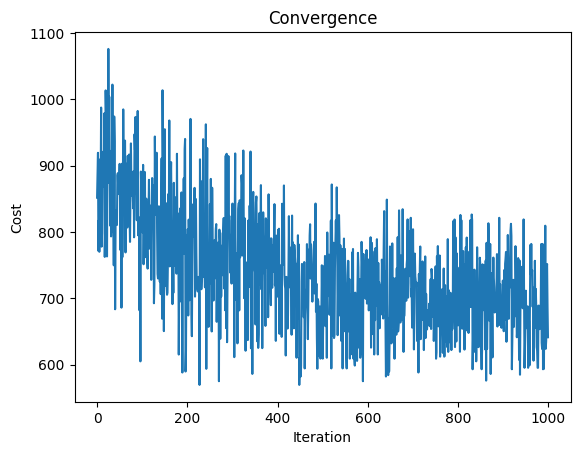

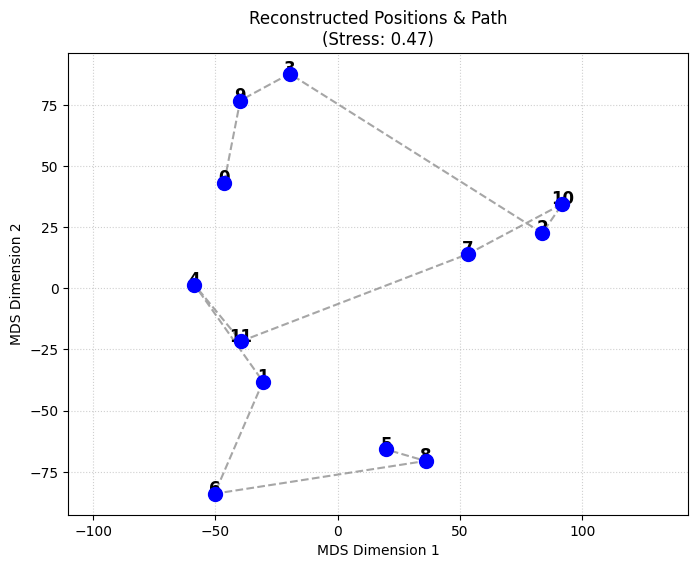

In [79]:
plot_convergence(history)
plot_graph_and_path(graph, best_path, False)

## 9. Rövid szöveges beszámoló

Ide írd a paramétereket, eredményeket és a következtetéseket.

- Beállítások:
  - Graph: 12 pont
  - N_Ants: 12
  - N_Iters: 1000,
  - tau0: 0.1
  - start: 0
  - goal: 5
  - alpha: 1.0
  - rho: 0.1
  - Q: 400
- Eredmények:
  - A hangyak fokozatosan egyre jobb utat talalnak, a konvergencia abran jol lathato a fejlodes idovel
  - A legjobb ut a grafra 570 hosszusag, az elejen meg kb 1300rol indulnak randomizalva
- Következtetések:
  - Fontos problema a Q jo megvalasztasa, mert nagy lehet a kulonbseg az alap feromon erosseg es a hozza adott osszegek kozott
  - konnyu hibat elvetni az algoritmusba, pl sok gondot okozott hogy hogyan frissitem a feromonokat, veletlenul minden uton minden pontnak minden szomszedjahoz adtam
  - ezekkel a beallitasokkal, lassu de stabil javulas lathato hosszu tavon
  - a legjobb eredmeny ugy volt, ha ugyan annyi hangya mint ahany pont